# __Scenario C:__<br>SLAC characterization

Data provided by Alaric Prins (Applied Microbial and Health Biotechnology Institute, Cape Peninsula University of Technology, Capetown, South Africa)

## Project background
The small laccase from *Streptomyces coelicolor* (SLAC) is a member of the muticopper oxidase family. Due to their potential to oxidize various electron-rich substrates, laccases are of interest for industrial application for lignin degradation {cite}`widsten2008laccase`. In a previous study, mutations around T1 Cu of SLAC showed significant biochemical changes {cite}`prins2015effect`. Therefore, the catalytic properties of mutated SLAC were investigated in a broad pH and temperature range.

### Experimental design
In this scenario the enzymatic oxidation of 2,2'-Azino-bis(3-ethylbenzothiazoline-6-sulfonic acid) (ABTS) to its radical form ABTS<sup>+·</sup> was studied in the pH range of pH 3&nbsp;-&nbsp;pH&nbsp;5.5 and temperature range of 25°C&nbsp;-&nbsp;45°C. In total 30 kinetic enzyme assays in a substrate range between 0&nbsp;-&nbsp;200&nbsp;uM of ABTS were conducted. Additionally, for each enzyme reaction with a given initial substrate concentration, a control reaction without enzyme was prepared.  
For each pH - temperature condition an individual ABTS standard curve and absorption spectrum was recorded to account for varying ABTS absorption properties due to reaction conditions. Each enzyme reaction was followed for 15 min photometrically at two wavelengths, measuring substrate depletion and product accumulation simultaneously. Preliminary experiments confirmed, that ABTS absorbs at 340 nm, whereas the ABTS<sup>+·</sup> absorbs at 420 nm in contrast to the substrate. Furthermore, cross absorbance of product at the substrate detection wavelength and vice versa was ruled out.

### Data management
Overall, the dataset consists of more than 100&nbsp;000 individual absorbance reads. Thus, data preparation was automated by custom parser functions, which were tailored to the output of the used spectrophotometer. Consequently, the tedious and error-prone manual copying of raw data was avoided. Information on the involved reactants, and the enzyme was filled in an EnzymeML Excel spreadsheet, which served as a meta data container. All other information was parsed from the output of the spectrophotometer. Fig. 7 illustrates the schematic data flow of this project.


![Fig. 7](../images/workflow_SLAC.png)
_Fig. 7: Schematic data pipeline of the SLAC project._

## Data preparation

### Imports

In [6]:
from typing import Dict, List
import pyenzyme as pe
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import string
from lmfit import Parameters, minimize
from scipy.stats import linregress, pearsonr
from joblib import Parallel, delayed
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator

# Custom functions for data mapping
from parser_functions import measurement_data_to_EnzymeML, plot
from parser_functions import read_measurement_data, read_calibration_data
from parser_functions import add_enzyme_inactivation_model

import warnings
warnings.filterwarnings('ignore')

### Experimental data

Data from SLAC reactions was loaded from the output files of the photometer and written to individual EnzymeML documents. Then, information of the control reactions was used to subtract the absorption contribution from enzyme and buffer from the substrate and product signal.

In [7]:
# Specify the location of the data sets
directory_measurement_data = "../../data/SLAC_kinetic_characterization/TimeCourseData"
directory_standard_data = "../../data/SLAC_kinetic_characterization/StandardData"
directory_spectrum_data = "../../data/SLAC_kinetic_characterization/SpectrumData"
path_EnzymeML_templates = "../../data/SLAC_kinetic_characterization/EnzymeML_templates"

# Define IDs for species, listed in the EnzymeML Excel template
substrate_id = "s0"
product_id = "s1"
substrate_control_id = "s2"
product_control_id = "s3"
species_ids = [substrate_id, product_id, substrate_control_id, product_control_id]


# Parse measurement data from photometer output
raw_data_dict = {}
for path in os.listdir(directory_measurement_data):
    data = read_measurement_data(f"{directory_measurement_data}/{path}")
    pH = data["pH"]
    temp = data["temperature"]
    raw_data_dict[f"{pH} {temp}"] = data

EnzymeML_template_dict = {
    3.0: "EnzymeML_SLAC_pH3.xlsm",
    3.5: "EnzymeML_SLAC_pH3_5.xlsm",
    4.0: "EnzymeML_SLAC_pH4.xlsm",
    4.5: "EnzymeML_SLAC_pH4_5.xlsm",
    5.0: "EnzymeML_SLAC_pH5.xlsm",
    5.5: "EnzymeML_SLAC_pH5_5.xlsm",
}

# Write absorption data to EnzymeMLDocuments
absortion_enzymemldocs: List[pe.EnzymeMLDocument] = []
for name, data in raw_data_dict.items():
    pH = data["pH"]
    absortion_enzymemldocs.append(measurement_data_to_EnzymeML(
        template_path=f"{path_EnzymeML_templates}/{EnzymeML_template_dict[pH]}",
        measurement_data=data,
        species_ids=species_ids,
        data_unit="umole / l",
        time_unit="s"))

# Sort documents by ascending pH and temperature
absortion_enzymemldocs = sorted(absortion_enzymemldocs, key=lambda x: (x.getReaction("r0").ph, x.getReaction("r0").temperature))

# Blanc measurement data
for enzmldoc in absortion_enzymemldocs:
    blanc_measurement = enzmldoc.measurement_dict["m0"].getReactant("s0").replicates
    blanc = np.mean([repeat.data for repeat in blanc_measurement])

    for id, measurement in enzmldoc.measurement_dict.items():
        for rep, replicate in enumerate(measurement.getReactant("s0").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s0").replicates[rep].data = blanced_data
        for rep, replicate in enumerate(measurement.getReactant("s2").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s2").replicates[rep].data = blanced_data

        for rep, replicate in enumerate(measurement.getReactant("s1").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s1").replicates[rep].data = blanced_data
        for rep, replicate in enumerate(measurement.getReactant("s3").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s3").replicates[rep].data = blanced_data
    
    # Delete control measurement 'm0'
    del enzmldoc.measurement_dict["m0"]

### Concentration calculation

Calibration data was loaded and converted into individual instances of the calibration data model. Some meta data of the calibration needed to be provided to the custom ```read_calibration_data``` function, since the output of the used spectrophotometer only contained a minimum of information. Thereafter, a StandardCurve was created for each calibration data set. Thereby, only absorption values below 3.2 were considered, since higher absorption values could not be converted into concentration accurately. 
Lastly, the fit of each standard curves was visualized.

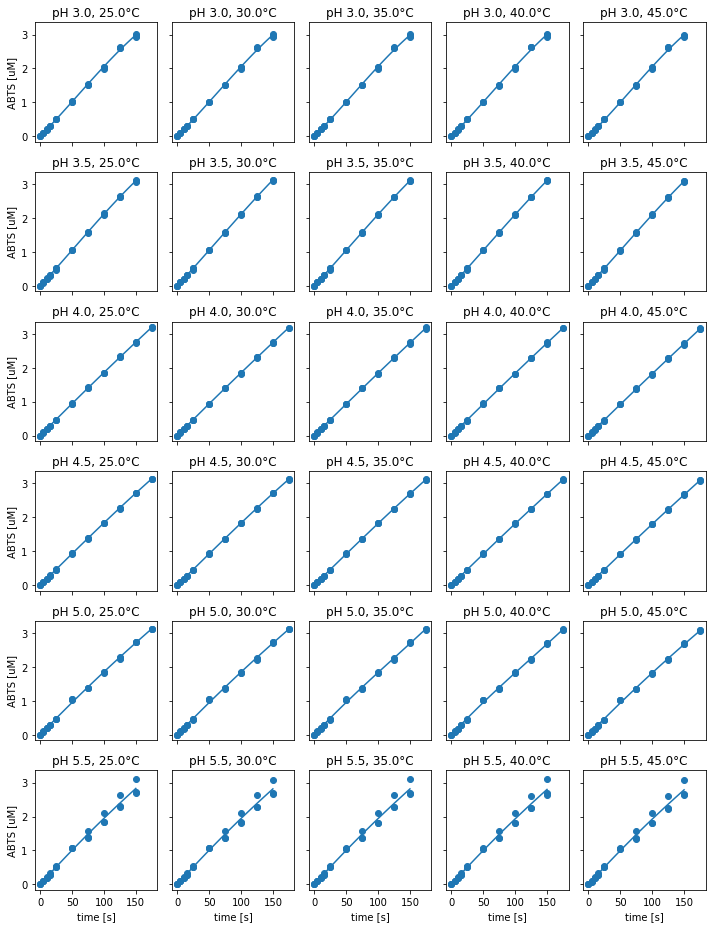

In [8]:
# Load calibration raw data
calibration_data = []
standard_directory = np.sort(os.listdir(directory_standard_data))
spectrum_directory = np.sort(os.listdir(directory_spectrum_data))

for standard, spectrum in zip(standard_directory, spectrum_directory):
    standard = f"{directory_standard_data}/{standard}"
    spectrum = f"{directory_spectrum_data}/{spectrum}"
    result = read_calibration_data(
        path_standard=standard,
        path_spectrum=spectrum,
        species_id=substrate_id,
        wavelengths=[340, 420],
        concentrations=[0,5,10,15,25,50,75,100,125,150,175,200],
        concentration_unit="umole / l",
        device_manufacturer="Molecular Devices",
        device_model="SpectraMax i3x",
        spectrum_reactant_concentration=100
    )
    for pH in result.keys():
        calibration_data.append(result[pH])

# Sort calibration data by ascending pH and temperature
calibration_data = sorted(calibration_data, key = lambda x: (x.pH, x.temperature))

# Generate standard curves for ABTS calibration data
standard_curves: List[StandardCurve] = []
for calibration in list(calibration_data):
    standard_curves.append(StandardCurve(calibration_data=calibration, wavelength=340, cutoff_absorption=3.2, show_output=False))

# Sort standard curves by ascending pH and temperature.
standard_curves = sorted(standard_curves, key = lambda x: (x.calibration_data.pH, x.calibration_data.temperature))

# Visualize all fitted standard curves 
fig, axes = plt.subplots(6,5, figsize=(10, 13), sharey=True, sharex=True)
for i, (standard, ax) in enumerate(zip(standard_curves[:30], axes.flatten())):
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    standard.visualize(ax=ax)
    ax.set_title(f"pH {standard.calibration_data.pH}, {standard.calibration_data.temperature}°C")
    if i in [25,26,27,28,29]:
        ax.set_xlabel("time [s]")
plt.tight_layout()

_Fig. 8: ABTS standard curves for different experimental condition._

Since the absorption characteristics of ABTS change with pH, the calibration range differs between pH values, due to the upper absorption limit (Fig. 8). In consequence, the upper calibration limit for reactions at pH 3, pH 3.5, and pH 5.5 is at 150 uM of ABTS, whereas for all other pH values the upper limit is at 175 uM. This might source from the protonation state of ABTS, since the sulfonate groups of ABTS are deprotonated for less acidic pH values. Therefore, the absorption properties of ABTS can decrease. Calibration curve data at pH 5.5 showed larger variation between the repeats. In this case, pipetting of one of the three repeats differs from the other two, which should be considered for kinetic parameter estimation. In contrast to pH, the temperature during calibration affected the calibration curve only marginally.  

The generated standard curves were used to convert the absorption measurement data into concentration data. Thereby, the respective concentration values were only calculated, if the measured absorption was within the respective calibration bounds to avoid extrapolation.

In [9]:
# Calculate concentrations by applying standard curves to 'EnzymeMLDocuments'.
concentration_enzymemldocs = []
for standard_curve, abso_enzmldoc in zip(standard_curves, absortion_enzymemldocs):

    # Validate, that measurement data is paired with respective standard curve
    assert standard_curve.calibration_data.pH == abso_enzmldoc.getReaction("r0").ph
    assert standard_curve.calibration_data.temperature == abso_enzmldoc.getReaction("r0").temperature

    enzmldoc = copy.deepcopy(abso_enzmldoc)
    conc_enzmldoc = standard_curve.apply_to_EnzymeML(enzmldoc, "s0", ommit_nan_measurements=True)
    conc_enzmldoc = standard_curve.apply_to_EnzymeML(enzmldoc, "s2", ommit_nan_measurements=True)

    concentration_enzymemldocs.append(conc_enzmldoc)

Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m8']' removed from document, since respective measurement values are out of calibration range.
M

## Quality control through mass balance analysis

Since product and substrate of the SLAC reaction were simultaneously recorded, mass balance analysis was conducted as a control of quality. By assuming mass conservation, the following concentration balance can be established:  
```{math}
:label: mass_balance
0 = S_{(t)} + P_{(t)} - S_{0}
```
Thereby, $S_{0}$ denotes the initial substrate concentration, whereas $S_{(t)}$ and $P_{(t)}$ describe the substrate and product concentration for each time point $t$. $S_{t}$ and $S_{0}$ were individually measured. Thus each enzyme reaction with a given initial substrate concentration had a control reaction with identical substrate concentration. In contrast to the substrate, no calibration standard was available for the product. Therefore, an additional parameter $k$ was introduced to the mass balance equation, assuming linear relationship between the product concentration and its signal:  

```{math}
:label: mass_balance_with_k
0 = S_{(t)} + P_{(t)}k - S_{0}
```

$k$ was determined for each data set individually by a minimization algorithm. The minimization objective was to find the optimal $k$, which minimizes all slopes of an experiment. If the slopes are zero, mass conservation is given over the observed time-course. Mass balances of all measurements are visualized in Fig. 9.


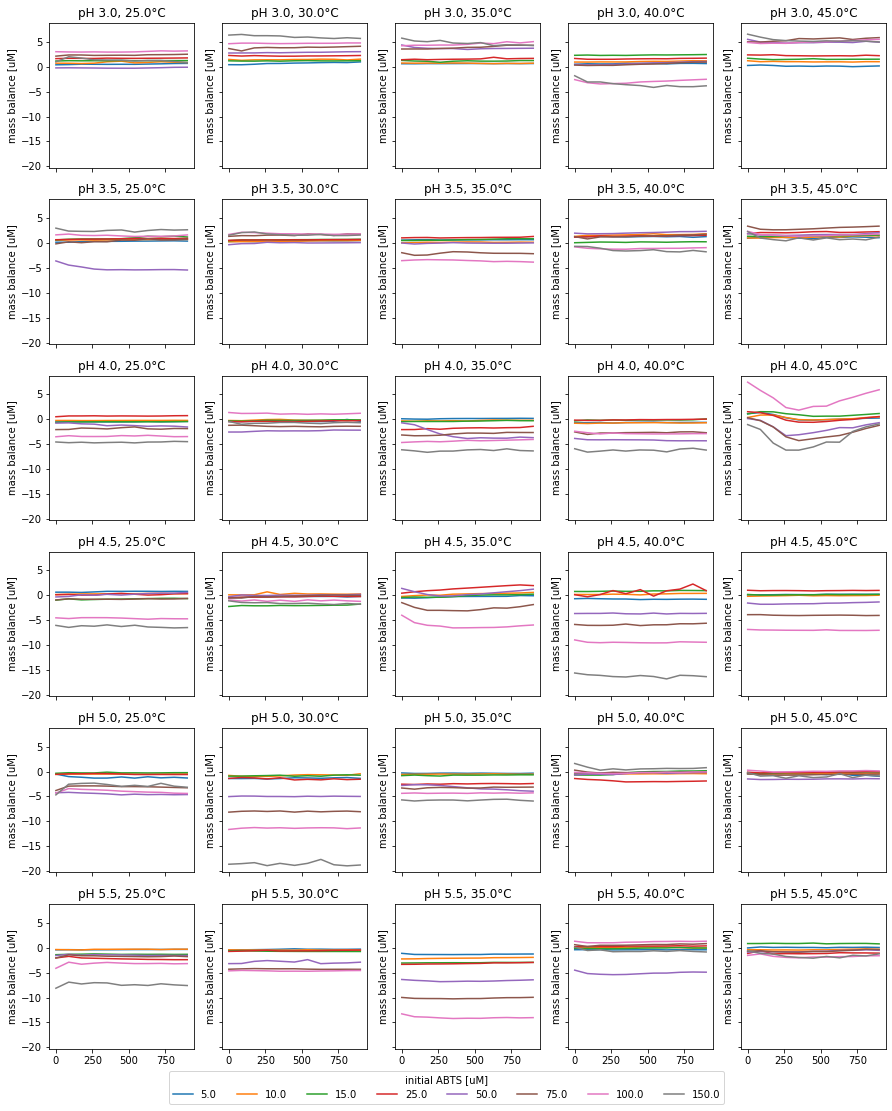

In [10]:
# Defenition of parameter 'k'
params = Parameters()
params.add("k", value=30, min=0, max=200)

# Target function for the minimizer
def residual(params, x):
    k=params["k"]

    substrate, product,  control = x
    slopes = substrate[:,0] * 0.0
    for i, (s, p, c) in enumerate(zip(substrate, product, control)):
        sub = np.mean(s, axis=0)
        prod = np.mean(p, axis=0)
        cont = np.mean(c, axis=0)

        model = sub + prod*k - cont

        slopes[i] = linregress(np.arange(len(model)), model)[0]

    return slopes.flatten()


f = []
fig, axes = plt.subplots(6,5, figsize=(12.5, 15), sharey=True, sharex=True)
for e, (doc, ax) in enumerate(zip(concentration_enzymemldocs, axes.flatten())):
    substrate = []
    product = []
    initial_substrate = []
    control = []
    for measurement in doc.measurement_dict.values():
        initial_substrate.append(measurement.getReactant(substrate_id).init_conc)
        for replicate in measurement.getReactant(substrate_id).replicates:
            substrate.append(replicate.data)
        for replicate in measurement.getReactant(product_id).replicates:
            product.append(replicate.data)
        for replicate in measurement.getReactant("s2").replicates:
            control.append(replicate.data)

    time = np.array(replicate.time)

    product = np.array(product).reshape(int(len((product))/3),3,11)
    substrate = np.array(substrate).reshape(int(len((substrate))/3),3,11)
    control = np.array(control).reshape(int(len((control))/3),3,11)
    initial_substrate = np.array(initial_substrate)

    x = (substrate, product, control)

    result = minimize(residual, params, args=(x,))

    factor = result.params["k"].value
    f.append(factor)

    for i, (s, p, c, l) in enumerate(zip(substrate, product,  control, initial_substrate)):
        init = np.mean(c, axis=0)
        sub = np.mean(s, axis=0)
        prod = np.mean(p, axis=0)
        cont = np.mean(c, axis=0)
        balance = (sub + prod*factor - cont)

        ax.plot(doc.getMeasurement("m1").getReactant("s0").replicates[0].time, balance, label = l)
        if not i%5:
            ax.set_ylabel("mass balance [uM]")
        if i in [24, 25, 26, 27, 28, 29]:
            ax.set_xlabel("time [s]")
        pH = doc.getReaction("r0").ph
        temp = doc.getReaction("r0").temperature
        ax.set_title(f"pH {pH}, {temp}°C")#, factor: {factor:.0f}")
    if e == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.03))
plt.tight_layout()



_Fig. 9: Quality control of each experiment through modeled mass balance._

For all experiments, except for pH 4, 45°C and pH 4.5, 35°C, the product and substrate is in qualitatively in balance over the reaction time-course, by visual analysis of Fig. 9. Mass balances, differing from 0 uM originate from differing substrate concentration in the enzyme reaction and the substrate control. In the reactions at pH 4, 45°C and pH 4.5, 35°C the mass balance slopes are not linear. This indicates issues with the measurement. Therefore, the respective measurements likely result in wrong parameter estimations.

## Kinetic parameter estimation

### Choice of kinetic model

Model selection is vital for parameter estimation. Thus, different settings for the parameter estimator were tested. Firstly, product inhibition models were excluded, since in some of the experiments the measured initial substrate concentration was higher than the specified one, which is used to calculate product concentrations. This resulted in calculated product concentrations with negative values.  
Secondly, substrate inhibition models were excluded, since the model was not able to describe the observed reaction kinetics. This was evident from a higher AIC as well as more than 100 % standard deviation on the estimated parameters.  
Lastly, the irreversible Michaelis-Menten model with and without time-dependent enzyme inactivation was compared, since enzyme inactivation was observed in previous experiments. Estimated parameters and the fitted models are shown for the experimental data at pH 3 and 25˚C under two scenarios - taking enzyme inactivation into consideration and, conversely, without enzyme inactivation (Fig. 10).

Estimated parameters without time-dependent enzyme inactivation:
Fitting data to:
 - irreversible Michaelis Menten model


,AIC,Km [umole / l],kcat / Km [1/s * 1/umole / l],kcat [1/s]
irreversible Michaelis Menten,-162,35.473 +/- 5.52%,0.009 +/- 5.89%,0.308 +/- 2.07%




Estimated parameters with time-dependent enzyme inactivation:
Fitting data to:
 - irreversible Michaelis Menten model


,AIC,Km [umole / l],kcat / Km [1/s * 1/umole / l],kcat [1/s],ki time-dep enzyme-inactiv. [1/s]
irreversible Michaelis Menten,-476,35.137 +/- 3.00%,0.013 +/- 3.58%,0.460 +/- 1.95%,0.001 +/- 4.47%


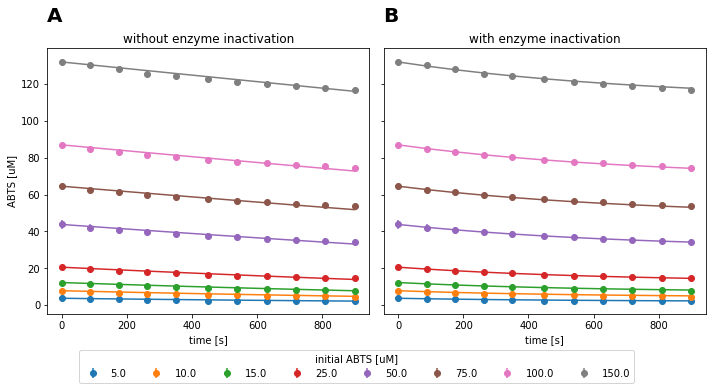

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.text(0, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    if i == 0:
        print("Estimated parameters without time-dependent enzyme inactivation:")
        kinetics = ParameterEstimator.from_EnzymeML(concentration_enzymemldocs[0], "s0", "substrate")
        kinetics.fit_models(only_irrev_MM=True)
        kinetics.visualize(ax=ax, title="without enzyme inactivation")
        ax.set_ylabel("ABTS [uM]")
        print("\n")
    else:
        print("Estimated parameters with time-dependent enzyme inactivation:")
        kinetics = ParameterEstimator.from_EnzymeML(concentration_enzymemldocs[0], "s0", "substrate")
        kinetics.fit_models(enzyme_inactivation=True, only_irrev_MM=True)
        kinetics.visualize(ax=ax, title="with enzyme inactivation")
    ax.set_xlabel("time [s]")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.09))
plt.tight_layout()

_Fig. 10: Fitted irreversible Michaelis-Menten model to experimental data of SLAC reaction at pH 3 and 25°C with and without considering time-dependent enzyme inactivation._

The model with enzyme inactivation describes the data better (Fig. 10B). This is characterized through a lower AIC, as well as lower standard deviations on the estimated parameters. 
In absolute terms, the estimated $K_{m}$ of both models is approximately identical, whereas the $k_{cat}$ estimate is approximately 33% lower for the model without enzyme inactivation. Hence, the model without enzyme inactivation underestimates the turnover number of the enzyme. As a result, irreversible Michaelis-Menten model with time-dependent enzyme inactivation was selected for the parameter estimation for all data sets.

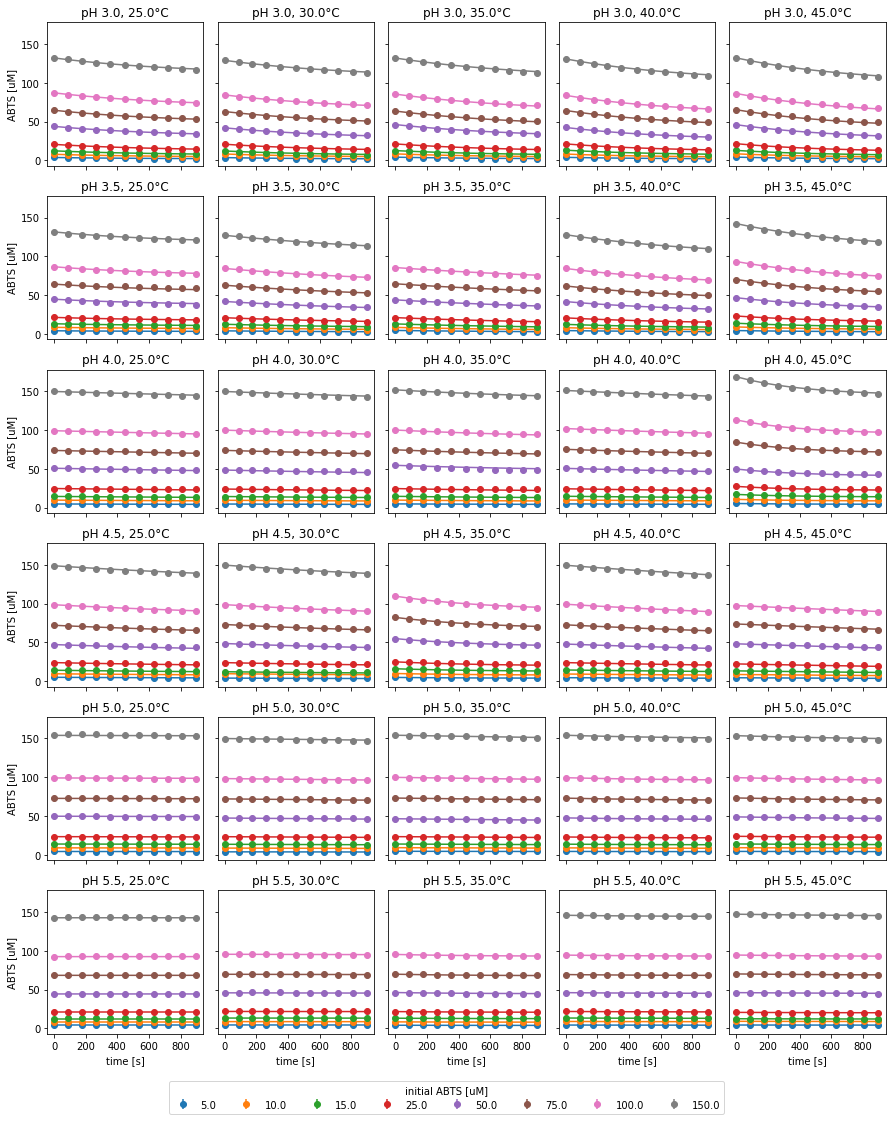

In [12]:
# Run parameter estimator for all datasets, utilizing multi-processing.
def run_ParameterEstimator(enzmldoc: pe.EnzymeMLDocument):    
    kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s0", "substrate")
    kinetics.fit_models(enzyme_inactivation=True, only_irrev_MM=True, display_output=False)
    return kinetics

results = Parallel(n_jobs=8)(delayed(run_ParameterEstimator)(enzmldoc) for enzmldoc in concentration_enzymemldocs)
results = sorted(results, key=lambda x: (x.data.pH, x.data.temperature))

# Visualize all fitted models
fig, axes = plt.subplots(6,5, figsize=(12.5, 15), sharey=True, sharex=True)
for i, (doc, ax) in enumerate(zip(results, axes.flatten())):
    ph = doc.data.pH
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    doc.visualize(ax=ax, title = f"pH {doc.data.pH}, {doc.data.temperature}°C")
    if i in [25,26,27,28,29]:
        ax.set_xlabel("time [s]")
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.04))
plt.tight_layout()

_Fig. 11: Experimental data and fitted irreversible Michaelis-Menten model with time-dependent enzyme inactivation of SLAC reactions under various conditions._

Experimental data as well as the fitted model are visualized in Fig 11. Based on the reaction slopes, no catalytic activity was observed for reactions at pH 5 or higher.
As in the mass balance analysis, the reactions at pH 4, 45°C and pH 4.5, 35°C differed from other experiments with identical pH. In both cases, all applied substrate concentration were higher than intended in the design of the experiment. Furthermore, the resulting parameter estimates have a high uncertainty. Therefore, the respective measurements were excluded from further analysis. Additionally, the results from pH 5.5, 35°C were excluded, since the uncertainty of the parameters could not be estimated. All calculated kinetic parameters are listed in the table below.

In [13]:
# Extract kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
pH = []
temperature = []
corr_kcat_km = []
for result in results:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)  

    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])

    pH.append(result.data.pH)
    temperature.append(result.data.temperature)

# Organize kinetic and experimantal parameters in a 'DataFrame'
df = pd.DataFrame.from_dict({
    'pH':pH, 
    "temperature [C]":temperature, 
    'kcat [1/s]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [uM]':Km, 
    'Km stderr':Km_std, 
    "Enzyme inactivation [1/s]":ki,
    "Enzyme inactivation std":ki_std,
    "correlation kcat/Km":corr_kcat_km})

df["kcat/Km [1/s * uM]"] = df["kcat [1/s]"] / df["Km [uM]"]
kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km [1/s * uM]"]
df["kcat/Km stderr"] = kcat_km_stderr

# Exclued results from failed experiments
df = df.drop(index=25) # reached parameter boundaries --> inactive
#df = df.drop(index=12) #Km really high stddev
df = df.drop(index=17) #kcat outlier, mass balance outlier
df = df.drop(index=14) #kcat outlier, mass balance outlier
df["zeros"] = np.zeros(27)

# Calculate halflife of enzyme
def calulate_halflife(x):
    return np.log(2)/x

df["half life [min]"] = df["Enzyme inactivation [1/s]"].apply(calulate_halflife)/60
df["half life std"] = df["Enzyme inactivation std"] / df["Enzyme inactivation [1/s]"] * df["half life [min]"]

# Delete inactivation rates
df = df.drop(columns=["Enzyme inactivation [1/s]", "Enzyme inactivation std"])
df


,pH,temperature [C],kcat [1/s],kcat stderr,Km [uM],Km stderr,correlation kcat/Km,kcat/Km [1/s * uM],kcat/Km stderr,zeros,half life [min],half life std
0,3.0,25.0,0.459962,0.008966,35.137357,1.053968,0.535141,0.013090,0.000468,0.0,9.139562,0.408568
1,3.0,30.0,0.470366,0.009855,32.114083,1.037088,0.522963,0.014647,0.000564,0.0,9.522170,0.476531
2,3.0,35.0,0.546029,0.016598,37.454496,1.765891,0.558865,0.014578,0.000818,0.0,10.304462,0.776312
3,3.0,40.0,0.712488,0.021754,46.441229,2.155285,0.608947,0.015342,0.000852,0.0,9.127765,0.600883
4,3.0,45.0,0.815724,0.022451,47.967746,2.047138,0.623270,0.017006,0.000864,0.0,9.087343,0.530573
5,3.5,25.0,0.420480,0.045642,89.752447,13.848584,0.746575,0.004685,0.000884,0.0,8.824513,1.680327
6,3.5,30.0,0.399649,0.007455,61.224383,1.674235,0.666682,0.006528,0.000216,0.0,14.545045,0.804521
7,3.5,35.0,0.246773,0.009247,28.237534,1.572755,0.554406,0.008739,0.000587,0.0,18.269277,2.766875
8,3.5,40.0,0.650031,0.012397,79.432405,2.189303,0.731830,0.008183,0.000274,0.0,11.026573,0.453021
9,3.5,45.0,0.978983,0.026556,103.784356,4.040850,0.774126,0.009433,0.000448,0.0,9.110325,0.425387


### High correlation between $k_{cat}$ and $K_{m}$

The parameter estimates for $k_{cat}$ and $K_{m}$ showed correlation. For experiments at pH 3 and pH 3.5, the parameters were correlated between *r<sup>2</sup>* = 0.5 - 0.85. This indicates, that the highest initial substrate concentration, which was applied for parameter estimation was not sufficiently high. Ideally, the highest initial substrate concentration applied for a kinetic experiment should be 10-fold higher than $K_{m}$ to allow independent estimates for $k_{cat}$ and $K_{m}$ {cite}`tipton2014standards`. In this scenario, only reactions with an initial substrate concentration up to 175 uM were used for parameter estimation, due to the limited photometric detection range of ABTS. Hence, ABTS was only applied 1.5-fold to 6-fold of the estimated $K_{m}$.  
For reactions at pH 4 and above, positive as well as negative correlations were observed. This might result from wrong parameter estimates, due to minimal enzyme activity at the given reaction conditions.

Catalytic efficiency for all experimental conditions is visualized in Fig. 12B, whereas the pH is color-coded. For reactions with identical pH values, $k_{cat}$ and $K_{m}$ both increase with temperature. This might be attributed to the high correlation between the parameters. Thus, the true change of $k_{cat}$ or $K_{m}$ through pH or temperature cannot be assessed with certainty. Therefore, the catalytic efficiency $\frac{k_{cat}}{K_{m}}$, was a better measure to assess the enzyme activity under different reaction conditions.

For reactions at pH 5 and above, almost no catalytic activity was observed. Therefore, data of these experimental conditions is excluded from further analysis. 

### Parameter estimates for $k_{cat}$ and $K_{m}$

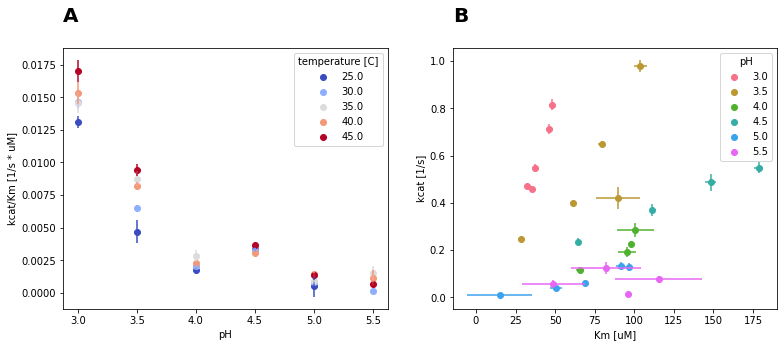

In [14]:
# Visualize estimated parameters
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=False, sharex=False)
for i, ax in enumerate(axes.flatten()):
    ax.text(0, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    if i==1:
        plot(df, xdata="Km [uM]", ydata="kcat [1/s]", xerror="Km stderr", yerror="kcat stderr", colors="pH", ax=ax)
    else:
        plot(df, xdata="pH", ydata="kcat/Km [1/s * uM]", xerror="zeros", yerror="kcat/Km stderr", colors="temperature [C]", ax=ax)
    

_Fig. 12: A: Catalytic efficiency of SLAC under different pH and temperature conditions. B: Kinetic parameters $k_{cat}$ and {K_{m}} estimates for SLAC reactions at different pH values._

$\frac{k_{cat}}{K_{m}}$ in relation to reaction pH is visualized in Fig. 12A. The highest catalytic efficiency was observed at pH 3 and 45°C. Increasing the pH by 0.5 reduced $\frac{k_{cat}}{K_{m}}$ approximately by half. For higher pH values, $\frac{k_{cat}}{K_{m}}$ is even further reduced. The catalytic efficiency is therefore highly sensitive to the pH. This might source from changes in the protonation state of either substrate or enzyme, hindering the efficient formation of the enzyme-substrate complex.
In terms of temperature, higher $\frac{k_{cat}}{K_{m}}$ was achieved at higher temperatures. SLAC might even be more active above 45°C and under pH 3, since in previous studies SLAC was the most active at 95°C {cite}`prins2015effect`.

### Time-dependent enzyme inactivation

The half life of SLAC was calculated with equation {eq}`enzyme_halflife` {cite:p}`Buxbaum2015`.
```{math}
:label: enzyme_halflife
t_{\frac{1}{2}} = \frac{ln(2)}{k_{inact}}
```

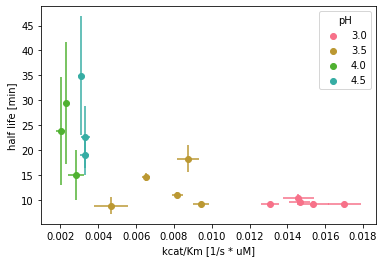

In [15]:
# Exclued inactive enzyme reactions above pH 4.5 and discard measurements with more than 100 % standard deviation on enzyme inactivation parameter
df = df.loc[:19]
df = df.drop(index=10) # more than 100 % standard deviation on enzyme inactivation parameter
df = df.drop(index=19) # more than 100 % standard deviation on enzyme inactivation parameter

# Plot half life over catalytic efficiency
plot(df, xdata="kcat/Km [1/s * uM]", ydata="half life [min]", xerror="kcat/Km stderr", yerror="half life std", colors="pH")
plt.show()

The enzyme's calculated half life was between 8 - 18 min for reactions at pH 3 and pH 3.5, whereas enzyme reactions at higher pH values showed a half life between 15 - 35 min. Generally, reactions with higher catalytic efficiency showed a shorter half life compared to reactions with lower catalytic efficiency.
In order to check for corrections between $k_{inact}$, $k_{cat}$, $K_{m}$, $\frac{k_{cat}}{K_{m}}$, as well as the reaction temperature and pH, a correlation analysis was conducted across all datasets.

In [16]:
# Calculate correlations
df_corr = df.drop(columns=["kcat stderr", "Km stderr", "correlation kcat/Km", "kcat/Km stderr", "zeros", "half life std"])
rho = df_corr.corr()

# Visualize correlation heatmap
#sns.heatmap(rho, 
#        xticklabels=rho.columns,
#        yticklabels=rho.columns,
#        cmap = sns.color_palette("vlag", as_cmap=True))
#plt.show()

# Calculate confidence intercal for correlations
pval = df_corr.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05] if x<=t]))
rho.round(2).astype(str) + p

,pH,temperature [C],kcat [1/s],Km [uM],kcat/Km [1/s * uM],half life [min]
pH,1.0*,-0.15,-0.39,0.88*,-0.89*,0.8*
temperature [C],-0.15,1.0*,0.6*,0.07,0.27,0.03
kcat [1/s],-0.39,0.6*,1.0*,-0.03,0.58*,-0.49
Km [uM],0.88*,0.07,-0.03,1.0*,-0.75*,0.68*
kcat/Km [1/s * uM],-0.89*,0.27,0.58*,-0.75*,1.0*,-0.71*
half life [min],0.8*,0.03,-0.49,0.68*,-0.71*,1.0*


The above table shows correlation between between kinetic parameters and experimental conditions. Thereby, significant (p < 0.05) correlations are labeled with '*'. The half life of SLAC is significantly correlated to $\frac{k_{cat}}{K_{m}}$ as well as to pH. Due to correlation between $k_{cat}$ and $K_{m}$, the enzyme's half life is also correlated to $K_{m}$. Multiple reasons might be the reason for this observation. On the one hand, the observed correlation might be of technical origin. As such, the system of ordinary differential equations, describing the change in substrate and enzyme concentration, are not an accurate model for the reaction system. Therefore, high cross-correlation occurs, since individual observations cannot be attributed to individual parameters. On the other hand, enzyme activity and enzyme inactivation might be causally related. In this case, the formed ABTS radical might inactivate the enzyme by potential suicide inhibition, or the enzyme deteriorates through catalysis.

## Conclusion

### Data management
The established data pipeline allows scalable data preparation and analysis of enzyme kinetics experiments. In future experiments this workflow could be used to further expand the experimental parameter space. As a result, different enzymes with different substrates in different buffers at different temperatures and pH values could be analyzed.

### Correlation between parameters
The highest catalytic efficiency of SLAC was observed at pH 3 at 45°C and therefore on the edge of the investigated parameter space. Optimal reaction conditions might therefore be at an even lower pH and higher temperature. $k_{cat}$ and $K_{m}$ were correlated, which is likely the result of a too low initial substrate concentration in relation to the true $K_{m}$ of the enzyme at a given experimental condition. Hence, in adjoining experiments the product signal could be used for parameter estimation, since the concentration to absorbance ratio is lower compared to the one of the product. However, a reliable method for product quantification would need to be established first.

### Enzyme inactivation  
SLAC showed a short half life of approximately 10 min at reaction conditions with the highest catalytic efficiency, which was correlated to the catalytic efficiency. Further experiments are required to investigate the observed inactivation. This might be done by comparing the half life of SLAC with different substrates as well as higher enzyme concentrations.

## Save modeling results

Lastly, the modeling results are written to the EnzymeML documents and the files are exported.

In [18]:
for result, enzmldoc in zip(results, concentration_enzymemldocs):

    # Write modeling results to kinetic parameters
    k_cat = pe.enzymeml.models.KineticParameter(
        name="k_cat",
        value=result.get_model_results()["k_cat"].value,
        unit=f"1 / {result.data.time_unit}")

    K_m = pe.enzymeml.models.KineticParameter(
        name="K_m",
        value=result.get_model_results()["Km"].value,
        unit=result.data.data_conc_unit)

    # Define kinetic model
    model = pe.KineticModel(
        name="irreversible Michaelis-Menten",
        equation="-k_cat * p0 * s0 / (K_m + s0)",
        parameters=[k_cat, K_m])

    enzmldoc.getReaction("r0").model = model

    add_enzyme_inactivation_model(
        result=result,
        enzmldoc=enzmldoc)
    


    # Export EnzymeML documents
    export = False
    if export:
        enzmldoc.toFile()